<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/1/MLP_Basics_ModelEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from matplotlib import rcParams
# rcParams['figure.figsize'] = 15,7
plt.rc('figure', figsize=(12,7) )         # Image size

import seaborn as sns

import io, requests

import warnings
warnings.filterwarnings('ignore')

In [2]:
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 5 )

plt.rc('lines', markersize = 10 )

plt.rc('figure', figsize=(10,5) )         # Image size

In [3]:
def grid(x1, x2, off_set = .1, n_points = 100):
    ## d s show the range in the two varible. 
    d1 = x1.max() - x1.min()
    d2 = x2.max() - x2.min()
    
    x1_min, x1_max = x1.min() - off_set * d1 , x1.max() + off_set * d1
    x2_min, x2_max = x2.min() - off_set * d2 , x2.max() + off_set * d2

    ## This function from numpy gives a list of coordinates that are the points on the grid. 
    x, y = np.meshgrid(np.arange(x1_min, x1_max , d1/n_points), np.arange(x2_min, x2_max , d2/n_points) )

    return x , y 

# Good fit vs good model

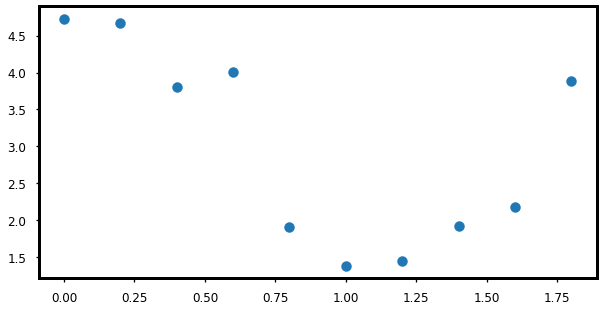

In [8]:
'''
We first need some data. Let's make some.
'''
eps = .5  # The amplitude of the noise. 
w_real = np.array([3, -6, 1, 4])
pol_feature = lambda x, deg: np.hstack([x**(deg-d) for d in np.arange(deg+1) ])
func = lambda x, w: w @ pol_feature(x, 3)

x_list = np.arange(0,2,.2).reshape(-1,1)
y_list = [func(x, w_real) + np.random.normal(0,eps) for x in x_list]

plt.scatter(x_list, y_list);

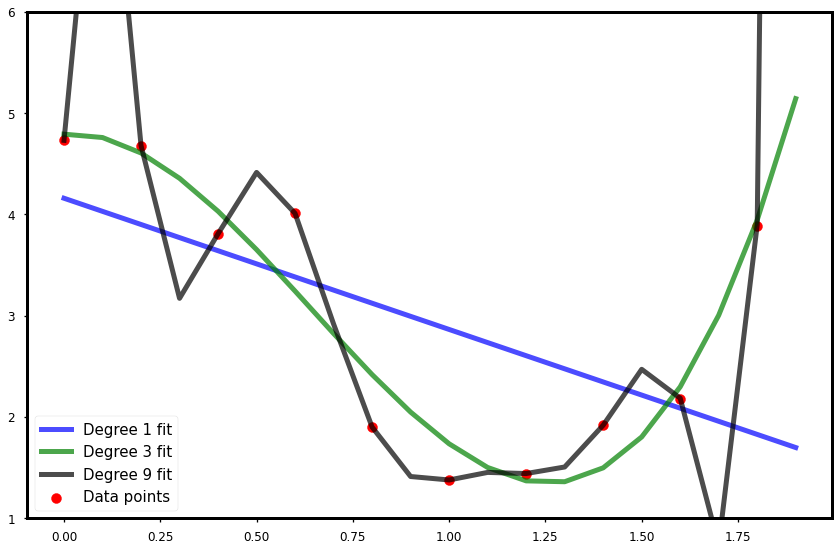

In [9]:
x_range = np.arange(0,2,.1).reshape(-1,1)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1 )
ax.scatter(x_list, y_list, s = 100, c = 'r', label='Data points')

deg_list = [1,3,9]
col_list = ['b', 'g', 'black']
ind = -1
for deg in deg_list:
  ind +=1
    ## Make the X matrix with powers of the x
  x_rg_in = pol_feature(x_list, deg)

  ## Construct m as X^T.X
  m = np.dot(x_rg_in.T,x_rg_in)

  ## This gives the w
  w = np.dot(np.linalg.inv(m),np.dot(x_rg_in.T, y_list))  

  ## Add the plot
  y_rg_list = np.dot(pol_feature(x_range, deg), w)
  
  ax.plot(x_range, y_rg_list, alpha=.7, c = col_list[ind], label=f'Degree {deg} fit')
    

plt.ylim((1,6))
plt.legend()
plt.tight_layout()
plt.show()    

# Recap

In [17]:
url = 'https://raw.githubusercontent.com/sraeisi/Machine_Learning_Physics_Winter20/master/Lec1/particle_mini.npz'
s=requests.get(url, stream=True).content
data=np.load(io.BytesIO(s) )
X, Y = data['X'], data['Y']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X , Y, random_state=0)


from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### Training the model
clf_pipeline= Pipeline([('scaler', StandardScaler() ), 
                        ('p_transformer', PolynomialFeatures(degree = 3)), 
                        ('clf', SGDClassifier())])
clf_pipeline.fit(X_train,Y_train)

### Testing the model
y_predict = clf_pipeline.predict(X_test)
out_error = np.abs(Y_test - y_predict).sum() / len(Y_test)

in_error = np.abs(Y_train - clf_pipeline.predict(X_train)  ).sum() / len(Y_train)

print(f'The in-sample error is {in_error:.4f}, and the out_sample error is {out_error:.4f}.')

The in-sample error is 0.0316, and the out_sample error is 0.0357.


In [20]:
from joblib import dump, load
dump(clf_pipeline, 'pipeline')

['pipeline']

In [22]:
model = load('pipeline')
model.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

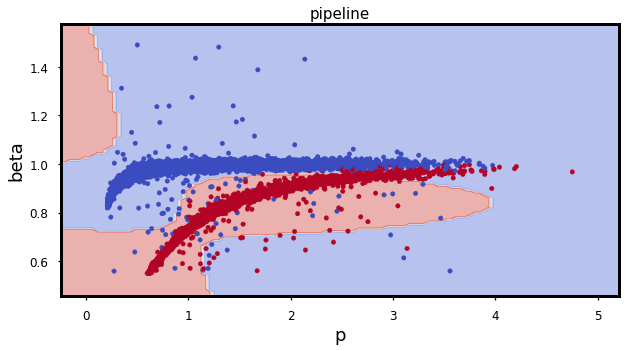

In [24]:
x1_list, x2_list = grid(X[:,0], X[:,1], n_points=100)
X_grid = np.vstack([x1_list.reshape(-1),x2_list.reshape(-1)]).T

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1 , xlabel = 'p', ylabel='beta', title = 'pipeline')
Y_grid = model.predict( X_grid ).reshape(x1_list.shape )

ax.contourf(x1_list, x2_list, Y_grid, alpha=.4, cmap=plt.cm.coolwarm)
ax.scatter(*X.T, c=Y, cmap=plt.cm.coolwarm, s=20)    
plt.show()